Dataset:https://datasets.simula.no/kvasir-seg/
Credits: 
https://keras.io/examples/vision/oxford_pets_image_segmentation/
https://github.com/DebeshJha/ResUNetPlusPlus-with-CRF-and-TTA/commits?author=DebeshJha


In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
from google.colab import drive; drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/IDL/Project_U-net/")
data_dir = '/content/drive/My Drive/Colab Notebooks/IDL/Project_U-net/Kvasir-SEG'

Mounted at /content/drive


In [ ]:
img_path = "/content/drive/My Drive/Colab Notebooks/IDL/Project_U-net/Kvasir-SEG/images"
files = os.listdir(img_path)
image_path = os.path.join(img_path, files[0]) 
img = cv2.imread(image_path, 1)
type(img)

numpy.ndarray

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "images", id_name) 
        mask_path = os.path.join(self.path, "masks",id_name)
        # all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = cv2.imread(mask_path,  0)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, -1)
        
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        random.shuffle(self.ids)
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

# Hyperparameter

In [ ]:
image_size = 128
img_path = "/content/drive/My Drive/Colab Notebooks/IDL/Project_U-net/Kvasir-SEG/images"
files = os.listdir(img_path)

#file ids
train_ids = files[:800]
valid_ids = files[800:900]
test_ids = files[900:1000]

epochs = 5
batch_size = 8

train_path = "/content/drive/My Drive/Colab Notebooks/IDL/Project_U-net/Kvasir-SEG"


In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


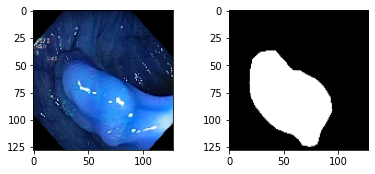

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.squeeze(y[r]), cmap="gray")

# Convolution Block

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
100/100 [==============================] - 234s 2s/step - loss: 0.4061 - acc: 0.8431 - val_loss: 0.3983 - val_acc: 0.8110
Epoch 2/5
100/100 [==============================] - 157s 2s/step - loss: 0.3492 - acc: 0.8436 - val_loss: 0.4072 - val_acc: 0.8216
Epoch 3/5
100/100 [==============================] - 158s 2s/step - loss: 0.3438 - acc: 0.8436 - val_loss: 0.4052 - val_acc: 0.8019
Epoch 4/5
100/100 [==============================] - 158s 2s/step - loss: 0.3378 - acc: 0.8441 - val_loss: 0.3551 - val_acc: 0.8554
Epoch 5/5
100/100 [==============================] - 158s 2s/step - loss: 0.3359 - acc: 0.8463 - val_loss: 0.3952 - val_acc: 0.8127


# Test Model

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
test_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
x, y = test_gen.__getitem__(0)
result = model.predict(x)

result = result > 0.5

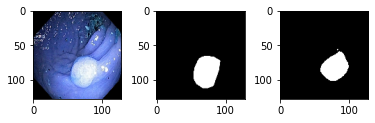

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[2])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[2]*255, (image_size, image_size)), cmap="gray")

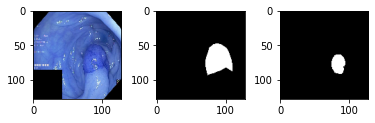

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[0])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")